In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Utils

In [ ]:
class Block(layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.h1 = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=self.kernel_size, strides=1, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.h2 = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=self.kernel_size, strides=1, padding='same'),
            layers.BatchNormalization(),
        ])

    def call(self, x, training=False):
        x_0 = x
        h1 = self.h1(x, training=training)
        h2 = self.h2(h1, training=training)
        out = h2 + x_0
        return out

class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.blocks = [Block(self.filters, self.kernel_size) for _ in range(3)]

    def call(self, x, training=False):
        x_0 = x
        for i in range(3):
            x = self.blocks[i](x, training=training)
        out = x + x_0
        return out

In [ ]:
class Encoder(models.Model):
    def __init__(self, C, filters, n_blocks):
        super().__init__()
        self.C = C
        self.filters = filters
        self.n_blocks = n_blocks
        self.res_blocks = [ResidualBlock(self.filters, 3) for _ in range(self.n_blocks)]
        self.h1 = models.Sequential([
            layers.Conv2D(self.filters // 2, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.h2 = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.block = Block(self.filters, 3)
        self.h3 = models.Sequential([
            layers.Conv2D(self.C, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization()
        ])

    def call(self, inputs, training=False):
        h1 = self.h1(inputs, training=training)
        x = self.h2(h1, training=training)
        x_0 = x
        for i in range(self.n_blocks):
            x = self.res_blocks[i](x, training=training)
        x = self.block(x, training=training)
        w = x + x_0
        w = self.h3(w, training=training)
        return w

In [ ]:
class Generator(models.Model):
    def __init__(self, filters, n_blocks):
        super().__init__()
        self.filters = filters
        self.n_blocks = n_blocks
        self.res_blocks = [ResidualBlock(self.filters, 3) for _ in range(self.n_blocks)]
        self.h1 = models.Sequential([
            layers.Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.block = Block(self.filters, 3)
        self.h2 = models.Sequential([
            layers.Conv2DTranspose(self.filters // 2, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.h3 = models.Sequential([
            layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization()
        ])

    def call(self, inputs, training=False):
        w_hat = self.h1(inputs, training=training)
        w_0 = w_hat
        for i in range(self.n_blocks):
            w_hat = self.res_blocks[i](w_hat, training=training)
        w_hat = self.block(w_hat, training=training)
        x_hat = w_hat + w_0
        x_hat = self.h2(x_hat, training=training)
        x_hat = self.h3(x_hat, training=training)
        return x_hat

In [ ]:
class Discriminator(models.Model):
    def __init__(self, filters):
        super().__init__()
        self.filters = filters
        self.net = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(self.filters // 2, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(self.filters // 4, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs, training=False):
        out = self.net(inputs, training=training)
        return out

## Preprocessing

In [ ]:
img = Image.open('gato.jpeg')

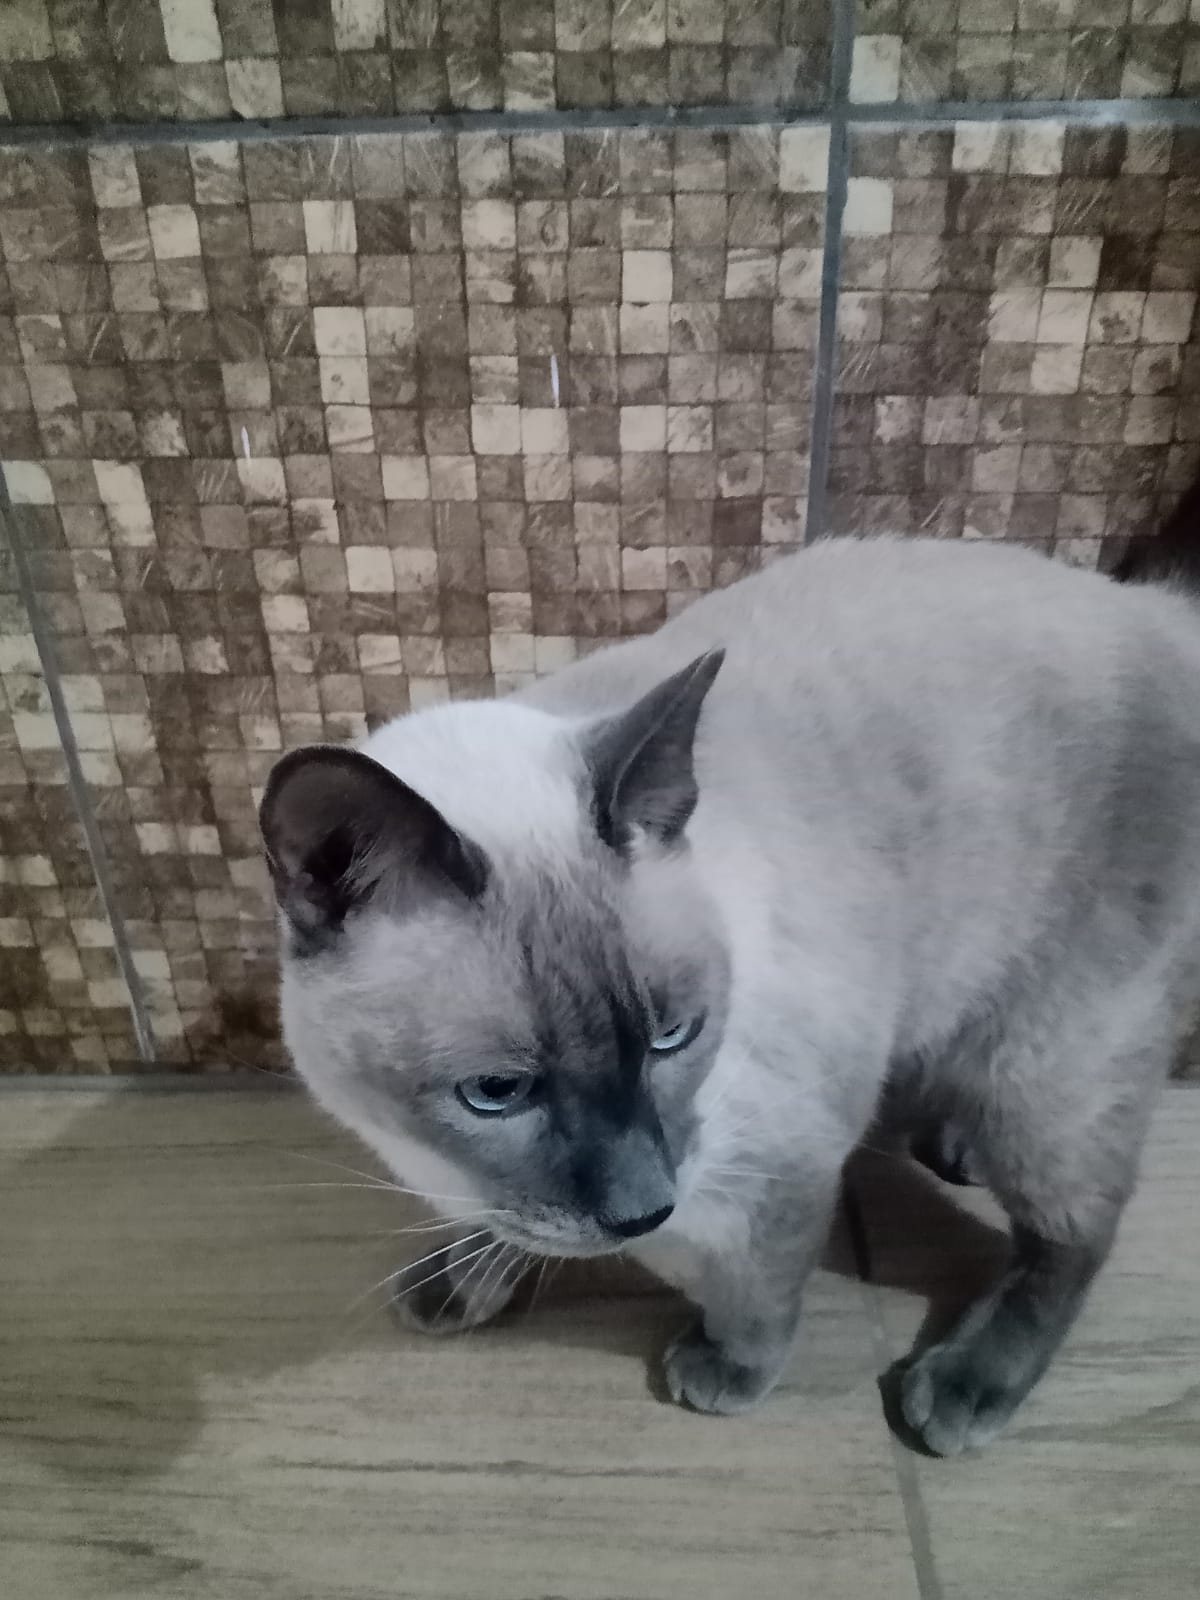

In [ ]:
img

In [ ]:
img.size

(1200, 1600)

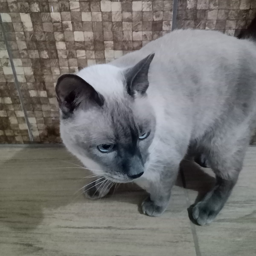

In [ ]:
img = img.crop((0, 400, 1200, 1600))
x = img.resize((256, 256))
x

In [ ]:
x = np.array(x)
x.shape, x.dtype

((256, 256, 3), dtype('uint8'))

In [ ]:
m = x.mean(axis=(0,1))
v = x.var(axis=(0,1))
(x - m).mean(axis=(0,1))

array([0., 0., 0.])

In [ ]:
def normalize_input(x):
    _mean = tf.convert_to_tensor([115., 114., 112.])
    _var = tf.convert_to_tensor([1450., 1510., 1700.])
    return (x - _mean) / tf.math.sqrt(_var + 1e-10)

In [ ]:
def denormalize_output(x_hat):
    _mean = tf.convert_to_tensor([115., 114., 112.])
    _var = tf.convert_to_tensor([1450., 1510., 1700.])
    x = x_hat * tf.math.sqrt(_var + 1e-10) + _mean
    x = tf.clip_by_value(x, clip_value_min=0, clip_value_max=255)
    return x

In [ ]:
x0 = normalize_input(x)

## Encoder

In [ ]:
encoder = Encoder(C=2, filters=128, n_blocks=5)

In [ ]:
# so pra poder o batchnormalization funfar
encoder.compile(optimizer=optimizers.Adam(learning_rate=0.002), loss='mean_squared_error')
encoder.train_on_batch(np.array([x0]), np.ones((1, 32, 32, 2)))

array(1.9999998, dtype=float32)

In [ ]:
w = encoder(np.array([x0]))
w = w.numpy()

In [ ]:
np.mean(w[0, :, :, :], axis=(0, 1)), np.var(w[0, :, :, :], axis=(0, 1))

(array([0.6735106 , 0.53096896], dtype=float32),
 array([3.8262699, 1.3459584], dtype=float32))

In [ ]:
w[0, :, :, 0].min()

-7.6692166

In [ ]:
w.shape

(1, 32, 32, 2)

## Quantizer

In [ ]:
def quantizer(L, c_min, c_max):
    """
    z: ndarray(B, H, W, C)
    L: int
    """
    def q(z):
        # convert z -> (B, C, H, W)
        z_t = tf.transpose(z, (0, 3, 1, 2))
        z_t_shape = tf.shape(z_t)
        B, C = z_t_shape[:2]
        z_vec = tf.reshape(z_t, [B, C, -1, 1])
        # definir array centers
        centers = np.linspace(float(c_min), float(c_max), L)
        # definir tensor dist
        dist = tf.square(tf.abs(z_vec - centers))
        # calcular tensor z_hat
        symbols = tf.reshape(tf.argmin(dist, axis=-1), z_t_shape)
        symbols = tf.transpose(symbols, (0, 2, 3, 1))
        z_hat = tf.convert_to_tensor(centers[symbols])
        return z_hat, symbols
    return q

In [ ]:
q = quantizer(5, -2, 2)
w_hat, symbols = q(w)

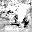

In [ ]:
w_vis = np.uint8(63*(w_hat + 2))
Image.fromarray(w_vis[0])

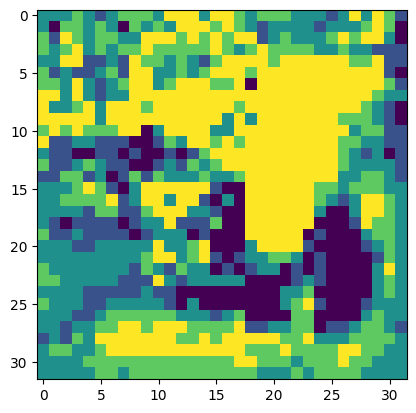

In [ ]:
plt.imshow(w_vis[0,:,:,0])

## Generator

In [ ]:
# generator = build_generator((32,32,2))
generator = Generator(filters=128, n_blocks=5)

In [ ]:
generator.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
generator.train_on_batch(w_hat, np.ones((1, 256, 256, 3)))

array(1.9961293, dtype=float32)

In [ ]:
w_hat.shape

TensorShape([1, 32, 32, 2])

In [ ]:
x_hat = generator(w_hat).numpy()

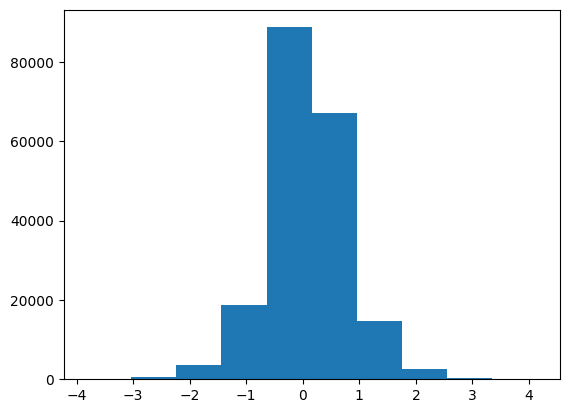

In [ ]:
plt.hist(x_hat[0].ravel());

In [ ]:
x_hat = np.uint8(denormalize_output(x_hat))

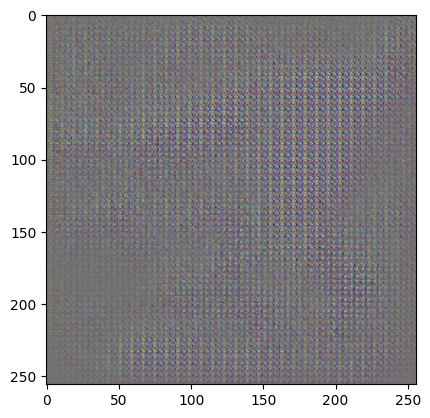

In [ ]:
plt.imshow(x_hat[0])

## Discriminator

In [ ]:
# disc = build_discriminator((256,256,3))
disc = Discriminator(filters=128)

In [ ]:
disc.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
disc.train_on_batch(np.array([x]), np.array([1]))

array(0.0363388, dtype=float32)

In [ ]:
disc(np.array([x])).numpy()

array([[0.6522025]], dtype=float32)

## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !tar -xf '/content/drive/MyDrive/gatonet/resized_crop_data.tar.xz' -C '/content/dataset'
!tar -xf '/content/drive/MyDrive/gatonet/cityscapes.tar.xz' -C '/content/dataset'

In [ ]:
# path_train = '/content/dataset/resized_crop_data/train_data'
# path_val = '/content/dataset/resized_crop_data/val_data'
path_train = '/content/dataset/data/train'
path_val = '/content/dataset/data/test'

datagen = ImageDataGenerator(rescale=1.0)

dataloader_train = datagen.flow_from_directory(
    path_train,
    target_size=(128, 256),
    batch_size=50,
    class_mode=None,  # Não estamos usando rótulos
    shuffle=True,
    classes=None,  # Ignorando qualquer subpasta que represente classes
    follow_links=True  # Para seguir links simbólicos, caso tenha
)

dataloader_val = datagen.flow_from_directory(
    path_val,
    target_size=(128, 256),
    batch_size=50,
    class_mode=None,  # Não estamos usando rótulos
    shuffle=True,
    classes=None,  # Ignorando qualquer subpasta que represente classes
    follow_links=True  # Para seguir links simbólicos, caso tenha
)

Found 2975 images belonging to 18 classes.
Found 1525 images belonging to 6 classes.


## Modelo

In [ ]:
class GenerativeCompressionGAN(models.Model):
    def __init__(self, encoder, generator, discriminator, num_centroids=5, lambda_recon=10, c_min = -2, c_max = 2):
        super(GenerativeCompressionGAN, self).__init__()
        self.encoder = encoder
        self.generator = generator
        self.discriminator = discriminator
        self.quantizer = quantizer(L=num_centroids, c_min = c_min, c_max = c_max)
        self.lambda_recon = lambda_recon  # Peso para a perda de distorção
        self.num_centroids = num_centroids  # Número de níveis de quantização

    def compile(self, d_optimizer, g_optimizer, gan_loss_fn, distortion_loss_fn):
        super(GenerativeCompressionGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.gan_loss_fn = gan_loss_fn  # Perda adversarial
        self.distortion_loss_fn = distortion_loss_fn  # Perda de distorção

    def __call__(self, data):
        real_images = normalize_input(data)
        # 1. Encode the image
        encoded_images = self.encoder(real_images)
        # 2. Quantize the latent space
        quantized_latent, _ = self.quantizer(encoded_images)
        # 3. Generate (Decode) image
        generated_images = self.generator(quantized_latent)
        return denormalize_output(generated_images), quantized_latent

    def evaluate(self, dataloader_val):
        d_loss_val = 0
        g_loss_val = 0

        for i in range(len(dataloader_val)):
            data = dataloader_val[i]
            data = tf.convert_to_tensor(data)
            real_images = normalize_input(data)
            # 1. Encode the image
            encoded_images = self.encoder(real_images)
            # 2. Quantize the latent space
            quantized_latent, _ = self.quantizer(encoded_images)
            # 3. Generate (Decode) image
            generated_images = self.generator(quantized_latent)


            real_output = self.discriminator(real_images)
            fake_output = self.discriminator(generated_images)

            # Perda adversarial do discriminador
            d_loss_real = self.gan_loss_fn(tf.ones_like(real_output), real_output)
            d_loss_fake = self.gan_loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss_batch = (d_loss_real + d_loss_fake) / 2
            d_loss_val += d_loss_batch


            # Perda adversarial para o gerador (Least-Squares GAN)
            g_gan_loss = self.gan_loss_fn(tf.ones_like(fake_output), fake_output)

            # Perda de distorção
            g_distortion_loss = self.distortion_loss_fn(real_images, generated_images)


            # Perda total ponderada
            g_loss_batch = g_gan_loss + self.lambda_recon * g_distortion_loss
            g_loss_val+= g_loss_batch

        d_loss_avg = d_loss_val/len(dataloader_val)
        g_loss_avg = g_loss_val/len(dataloader_val)

        return d_loss_avg, g_loss_avg





    def train_step(self, dataloader_train, epochs):

        d_loss = 0
        g_loss = 0

        # progressBar = tqdm(dataloader_train, desc='Epoch {:03d}'.format(epochs))
        # for data in progressBar:
        for i in tqdm(range(len(dataloader_train))):
            data = dataloader_train[i]
            data = tf.convert_to_tensor(data)
            real_images = normalize_input(data)
            # 1. Encode the image
            encoded_images = self.encoder(real_images)
            # 2. Quantize the latent space
            quantized_latent, _ = self.quantizer(encoded_images)
            # 3. Generate (Decode) image
            generated_images = self.generator(quantized_latent)

            # 4. Train the discriminator
            with tf.GradientTape() as tape:
                real_output = self.discriminator(real_images)
                fake_output = self.discriminator(generated_images)

                # Perda adversarial do discriminador
                d_loss_real = self.gan_loss_fn(tf.ones_like(real_output), real_output)
                d_loss_fake = self.gan_loss_fn(tf.zeros_like(fake_output), fake_output)
                d_loss_batch = (d_loss_real + d_loss_fake) / 2
                d_loss += d_loss_batch

                grads = tape.gradient(d_loss_batch, self.discriminator.trainable_weights)
                self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            # 5. Train the generator (GAN loss, distortion loss, entropy loss)
            with tf.GradientTape() as tape:
                generated_images = self.generator(quantized_latent)
                fake_output = self.discriminator(generated_images)

                # Perda adversarial para o gerador (Least-Squares GAN)
                g_gan_loss = self.gan_loss_fn(tf.ones_like(fake_output), fake_output)

                # Perda de distorção
                g_distortion_loss = self.distortion_loss_fn(real_images, generated_images)


                # Perda total ponderada
                g_loss_batch = g_gan_loss + self.lambda_recon * g_distortion_loss
                g_loss += g_loss_batch

                grads = tape.gradient(g_loss_batch, self.generator.trainable_weights)
                self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        d_loss_avg = d_loss/len(dataloader_train)
        g_loss_avg = g_loss/len(dataloader_train)

        return d_loss_avg, g_loss_avg

In [ ]:
def least_squares_gan_loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred) ** 2)

In [ ]:
# Build models

encoder = Encoder(C=2, filters=128, n_blocks=5)
generator = Generator(filters=128, n_blocks=5)
discriminator = Discriminator(filters=128)

# Instantiate and compile the GAN
gan = GenerativeCompressionGAN(encoder, generator, discriminator, num_centroids=5, lambda_recon=10)
gan.compile(
    d_optimizer=optimizers.Adam(learning_rate=0.001),
    g_optimizer=optimizers.Adam(learning_rate=0.001),
    gan_loss_fn=least_squares_gan_loss,
    distortion_loss_fn=tf.keras.losses.MeanSquaredError()
)

In [ ]:
epochs = 200

d_losses_train = []
g_losses_train = []

d_losses_val = []
g_losses_val = []

pbar = tqdm(range(1, epochs+1))
for epoch in pbar:
    tdl, tgl = gan.train_step(dataloader_train, epoch)
    vdl, vgl = gan.evaluate(dataloader_val)

    d_losses_train.append(tdl)
    g_losses_train.append(tgl)
    d_losses_val.append(vdl)
    g_losses_val.append(vgl)

    if epoch % 50 == 0:
        gan.save_weights(f'weights/gan_city_{epoch}.weights.h5')

    pbar.set_description(f'train: ({tdl:.2f}; {tgl:.2f}); val: ({vdl:.2f}; {vgl:.2f})')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

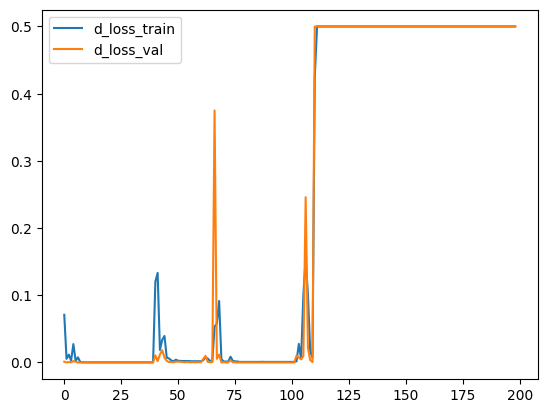

In [ ]:
plt.plot(d_losses_train[1:], label='d_loss_train')
plt.plot(d_losses_val[1:], label='d_loss_val')
plt.legend()
plt.savefig("figs/d_loss.png", dpi=300, bbox_inches='tight')

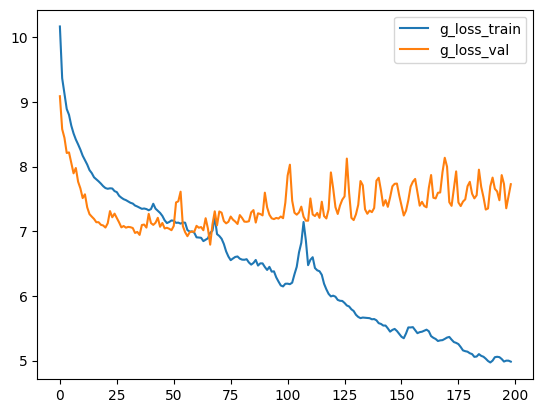

In [ ]:
plt.plot(g_losses_train[1:], label='g_loss_train')
plt.plot(g_losses_val[1:], label='g_loss_val')
plt.legend()
plt.savefig("figs/g_loss.png", dpi=300, bbox_inches='tight')

In [ ]:
# Baixa arquivos para o pc local
from google.colab import files
for epoch in range(50, epochs+1, 50):
    files.download(f'weights/gan_city_{epoch}.weights.h5')
files.download("figs/d_loss.png")
files.download("figs/g_loss.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
xhat, what = gan(dataloader_train[0])
shat = gan.discriminator(xhat)

In [ ]:
gan.summary()

Model: "generative_compression_gan_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_3 (Encoder)                  │ ?                           │       1,024,074 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ generator_3 (Generator)              │ ?                           │       1,022,031 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ discriminator_3 (Discriminator)      │ ?                           │          52,785 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,098,890 (8.01 MB)

 Trainable params: 2,091,616 (7.98 MB)

 Non-trainable params: 7,274 (28.41 KB)

In [ ]:
gan.load_weights('weights/gan_city_100.weights.h5')

In [ ]:
city_hat, city_w = gan(dataloader_val[0])
city_hat.shape

TensorShape([50, 128, 256, 3])

In [ ]:
plt.imsave("figs/orig_rua0.jpeg", np.uint8(dataloader_val[0][0]))

In [ ]:
plt.imsave("figs/rua0.jpeg", np.uint8(city_hat[0]))

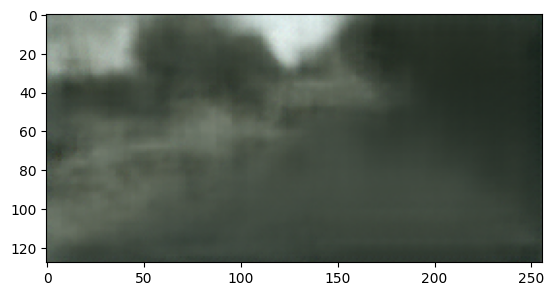

In [ ]:
plt.imshow(np.uint8(city_hat[0]))

In [ ]:
gan.evaluate(dataloader_val)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.889408>)

In [ ]:
xhat, what = gan(x[np.newaxis])

In [ ]:
plt.imsave("figs/gato_hat.jpeg", np.uint8(xhat[0]))

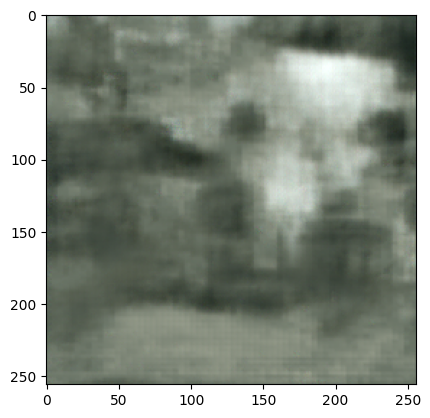

In [ ]:
plt.imshow(np.uint8(xhat[0]))


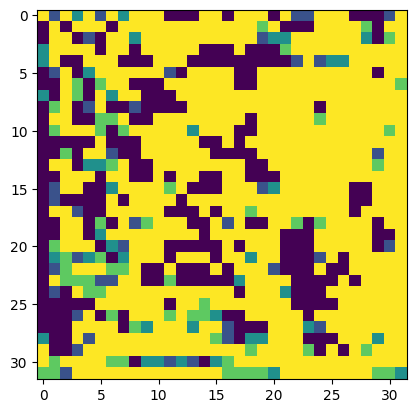

In [ ]:
plt.imshow(what[0, :, :, 0].numpy())